In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import qutip as qt
from scipy.linalg import expm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest, GradientBoostingRegressor
from sklearn.cluster import KMeans 

Data set collection:  
This dataset captures performance benchmarks for Post-Quantum Cryptography (PQC) algorithms, split into Key Encapsulation Mechanisms (KEM) for secure key exchange and Digital Signatures for authentication to evaluate the algorithms perform under different message sizes, measuring key operations like generation, encryption/signing, decryption/verification, overhead, and total time. 

 Collecting this helps:
- Identify trade-offs (speed vs. security vs. size) for applications like IoT (low overhead) or servers (high security).
- Train ML models (e.g., predict times for untested sizes).
- Support migration to PQC, ensuring correctness (all runs True) and quantifying overhead (e.g., ciphertext bloat).

Two files:
1. KEM Benchmark : Focuses on key exchange.
   - Columns: algorithm (e.g., BIKE-L1, Kyber512), keygen_time_ms (key pair gen time), encap_time_ms (encapsulate shared secret), decap_time_ms (decapsulate), ciphertext_length (encrypted size), shared_secret_length (secret size), overhead_bytes (extra size), total_time_ms (sum of times), correctness (True if secret recovered), type ("KEM"), text_size_kb (message size KB), text_length_bytes (bytes), run_id (1-1276 per algo), security_level_bits (128/192/256), security_level (1/2/3).
   - Example: BIKE-L1 at 0.5KB takes ~8ms keygen, total ~15ms, 1541 overhead bytes—efficient for level 1 security.

2. Digital Signature Benchmark : Focuses on signing/verification.
   - Columns: algorithm (e.g., Dilithium2, Falcon-512), keygen_time_ms (key pair gen), sign_time_ms (signing), verify_time_ms (verification), signature_length (sig size), overhead_bytes (sig - message size), total_time_ms (sum), correctness (True if verified), type ("Signature"), text_size_kb, text_length_bytes, run_id, security_level_bits, security_level.
   - Example: Dilithium2 at 0.5KB takes ~0.28ms signing, total ~0.34ms, 1908 overhead—fast for level 1.

Experiments were performed in a WSL2 Ubuntu environment for isolation and Linux tooling. The host system was an Intel Core i7 with 32GB RAM on Windows 11, providing consistent baseline performance without resource limits. The Open Quantum Safe (OQS) library (liboqs) was used for all tests, ensuring standardization, consistency, and up-to-date implementations of NIST PQC candidates.

In [2]:
kem_path = r"C:\Users\divya\Desktop\res\kem_benchmark_results.csv"
sig_path = r"C:\Users\divya\Desktop\res\signature_benchmark_results.csv"

df_kem = pd.read_csv(kem_path)
df_sig = pd.read_csv(sig_path)

Context 

IOT 

Eg 1: Smart Home Temperature Sensor

    Say ur designing smart temperature sensor for homes that connects to a central hub via Wi-Fi or Bluetooth, sending regular updates like current temperature, measurement time, device ID, and local configurations. 

    Cryptography is essential here for authentication, ensuring the hub verifies data from a trusted sensor to prevent fakes or hackers; integrity, to stop tampering in transit; and optional confidentiality, to encrypt sensitive readings if needed. In short, the model complies with the CIA triad.

    This requires signatures for verification and possibly key exchange/encryption.  Meaning we need both KEM and Dig sig.
    The sensor's priorities include speed for quick responses, low memory (64–128 KB RAM) to fit tiny chips like ARM Cortex-M0, low power for months-long battery life, and small key sizes for efficient transmission. 

Eg 2: Wearable Fitness Tracker

    A fitness tracker wristband syncing heart rate, steps, and sleep data to a smartphone app via Bluetooth sends bursts like readings, counts, user ID, and battery status.

    Ensuring authentication to verify genuine device data, integrity to prevent alterations (especially for med use), and confidentiality to protect health info, needing signatures, encryption, and key pairing.

    Priorities are speed for fast syncs, low memory (256 KB RAM on ARM Cortex-M4), ultra-low power for weeks on coin batteries, and small keys for compact form.

WebServer

Eg 1: E-Commerce Website TLS Handshake

    An e-commerce site handling logins, payments, and views over HTTPS processes session keys, credentials, details, and cookies in handshakes.

    authentication to prevent MITM, integrity for untampered requests (e.g., prices), and confidentiality for credit cards, requiring key exchange, signatures, and encryption. 

    Priorities include speed for low load times on 8-16 core servers with 16-64 GB RAM, scalability for 1,000+ users/sec, low overhead for CPU/network strain, and balanced security.

Eg 2: API Gateway for Cloud Services

    An API gateway for cloud services like AWS handles authentication for requests, tokens, payloads, and signatures. 

    Cryptography validates calls, prevents tampering, and encrypts responses, needing signatures and key exchange. 

    Priorities are speed for high volume on 32+ core clusters with 128+ GB RAM, scalability for distributed load, low memory for caching, and high security for keys/data

Mobile

Eg 1: Smartphone Banking App

    A banking app on Android/iOS for transactions and logins handles PINs, details, API calls, and notifications. 

    Cryptography secures logins, prevents alterations, and encrypts info, requiring key exchange and signatures. 

    Priorities include speed for quick responses on 4-8 core CPUs with 4-8 GB RAM, low power for battery, balanced memory for app size, and high security for finance.

Eg 2: Location-Tracking App for Delivery

    A delivery app tracking locations via GPS sends coordinates, ETAs, IDs, and updates. 

    Cryptography verifies data, prevents tampering, and protects locations, needing signatures and encryption. 

    Priorities are speed for real-time, low power for always-on GPS, small keys for data limits, and security for privacy.


Cloud

Eg 1: Distributed Storage Service

    A cloud storage like S3 manages file keys, tokens, metadata, and sync. 

    Cryptography verifies access, ensures integrity, and encrypts data, needing key exchange and signatures. 

    Priorities include scalability for 100k+ users, low overhead for costs, high security for breaches, and efficiency for ops.

Eg 2: Video Streaming Platform

    A streaming service like Netflix handles content keys, preferences, tokens, and DRM. 

    Cryptography verifies access, prevents tampering, and encrypts videos, needing key exchange and signatures. 

    Priorities are speed for seamless play, scalability for millions, low overhead for bandwidth, and high security for content.


Blockchain

Eg 1: Cryptocurrency Wallet App

    A wallet app signs transactions with hashes, addresses, amounts, and IDs. 

    Cryptography proves ownership, ensures integrity, and prevents denial, needing signatures and key exchange. 

    Priorities include speed for ops, low size for gas fees, high security against attacks, and scalability for peaks.

Eg 2: NFT Marketplace Platform

    An NFT app mints/trades art with metadata, IDs, prices, and royalties. 

    Cryptography verifies creators/buyers, prevents tampering, and proves ownership, needing signatures and key exchange. 

    Priorities are speed for mints, low size for costs, high security for value, and efficiency for auctions.

Hybrid

Eg 1: Secure Email Client

    An email app uses hybrid crypto for encrypted messages with headers, text, attachments, and keys. 

    Cryptography verifies senders, ensures integrity, and encrypts content, needing hybrid key exchange and signatures. 

    Priorities include compatibility with legacy, speed for experience, security for transition, and low overhead for data.

Eg 2: VPN Connection Manager

    A VPN app establishes tunnels with session keys, addresses, logs, and auth. 

    Cryptography verifies servers, protects traffic, and encrypts data, needing hybrid KEM and signatures. 

    Priorities are compatibility with old servers, speed for setup, low power for background, and security for privacy.


--- KEM Dataset EDA ---
Shape: (37004, 16)
Columns: ['algorithm', 'keygen_time_ms', 'encap_time_ms', 'decap_time_ms', 'ciphertext_length', 'shared_secret_length', 'overhead_bytes', 'total_time_ms', 'correctness', 'type', 'text_size_kb', 'text_length_bytes', 'run_id', 'timestamp', 'security_level_bits', 'security_level']
Unique Algorithms: 29 total - ['BIKE-L1' 'BIKE-L3' 'BIKE-L5' 'Classic-McEliece-348864'
 'Classic-McEliece-348864f' 'Classic-McEliece-460896'
 'Classic-McEliece-460896f' 'Classic-McEliece-6688128'
 'Classic-McEliece-6688128f' 'Classic-McEliece-6960119'
 'Classic-McEliece-6960119f' 'Classic-McEliece-8192128'
 'Classic-McEliece-8192128f' 'HQC-128' 'HQC-192' 'HQC-256' 'Kyber512'
 'Kyber768' 'Kyber1024' 'ML-KEM-512' 'ML-KEM-768' 'ML-KEM-1024'
 'sntrup761' 'FrodoKEM-640-AES' 'FrodoKEM-640-SHAKE' 'FrodoKEM-976-AES'
 'FrodoKEM-976-SHAKE' 'FrodoKEM-1344-AES' 'FrodoKEM-1344-SHAKE']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37004 entries, 0 to 37003
Data columns (t

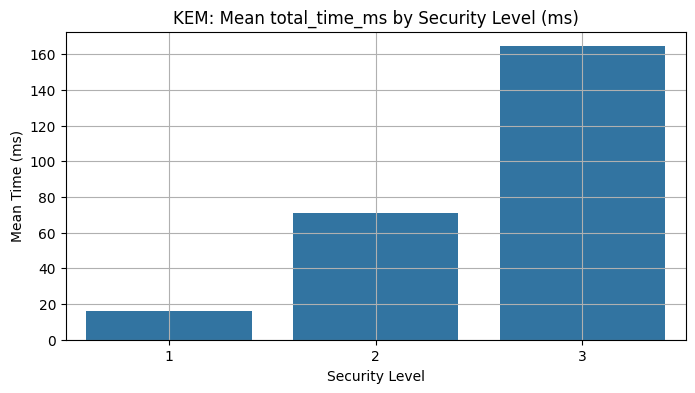

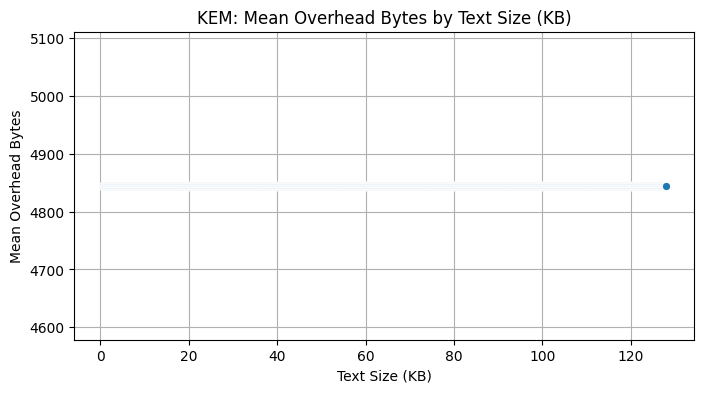

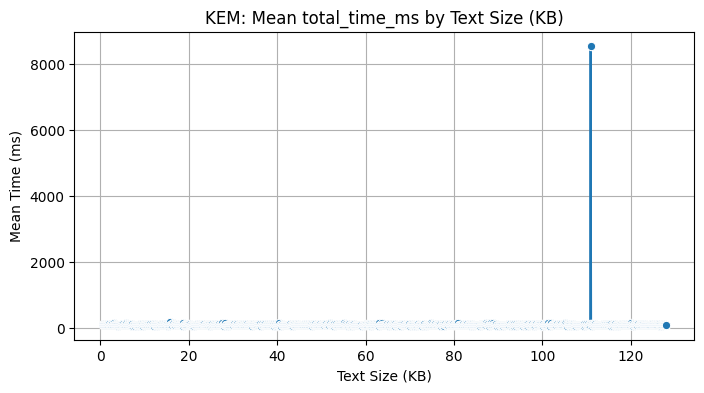

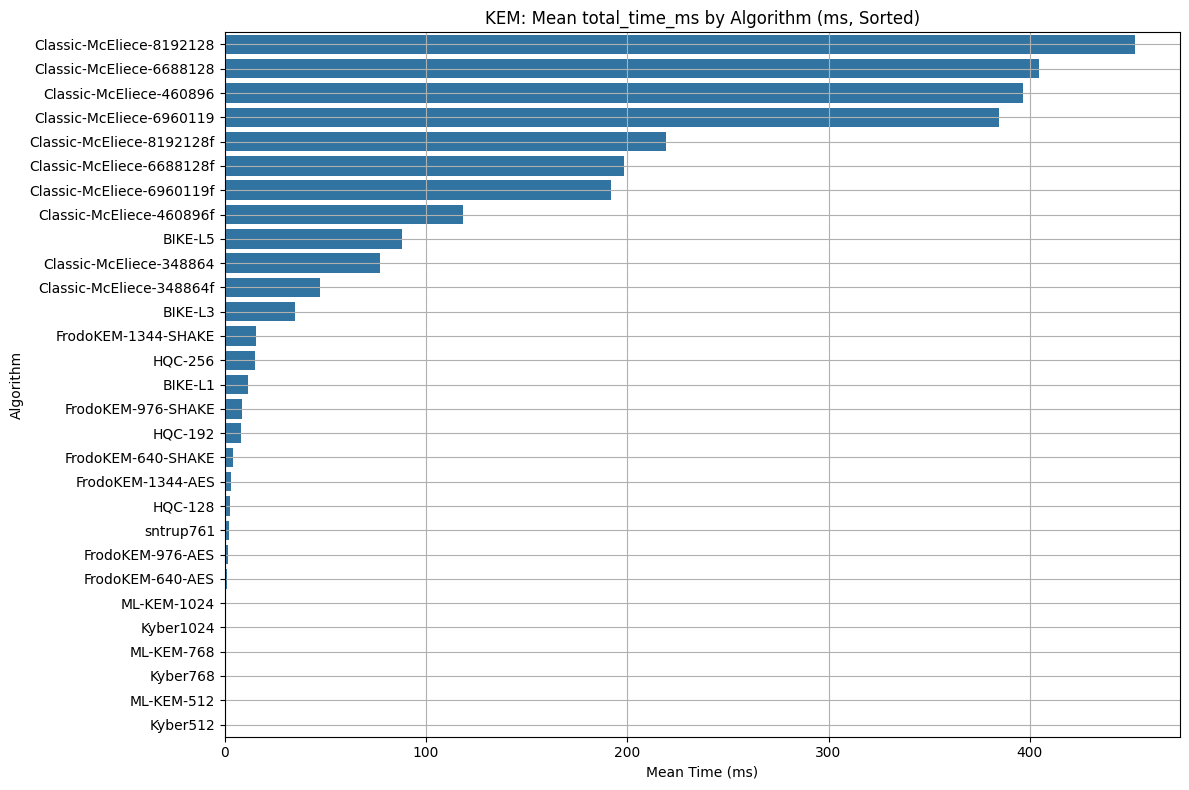

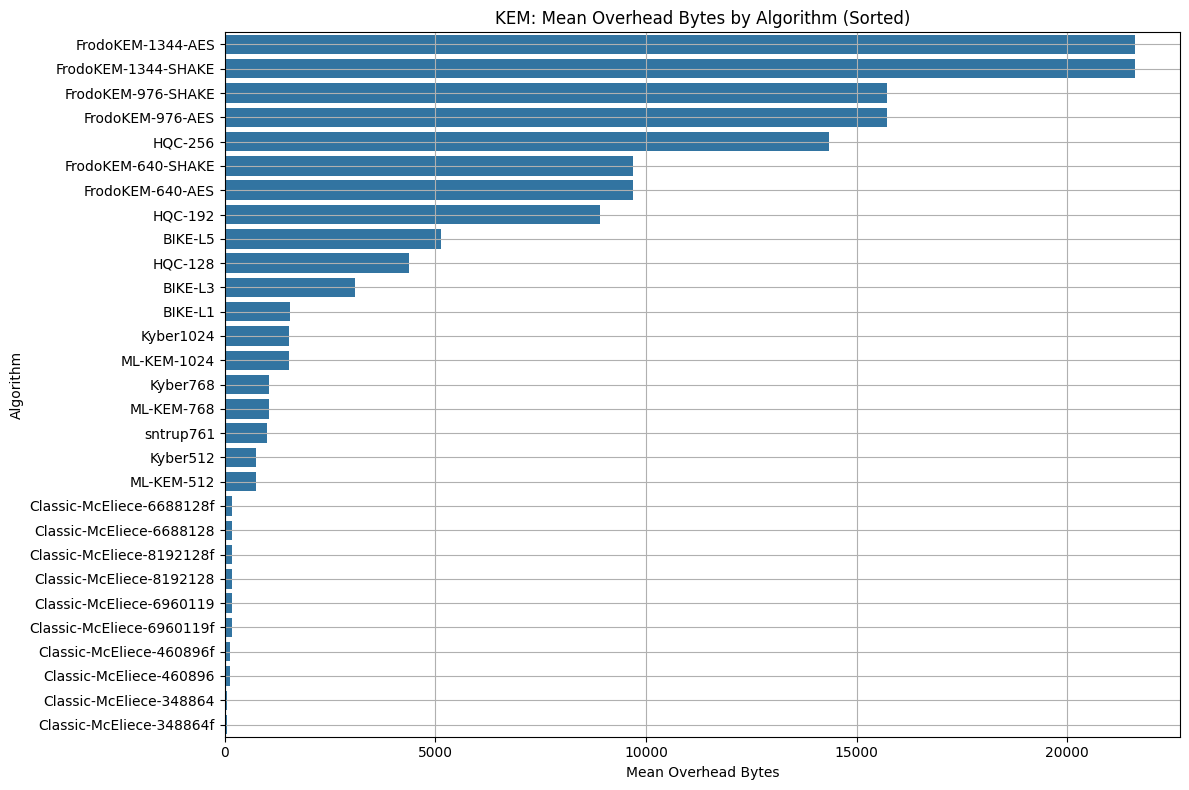

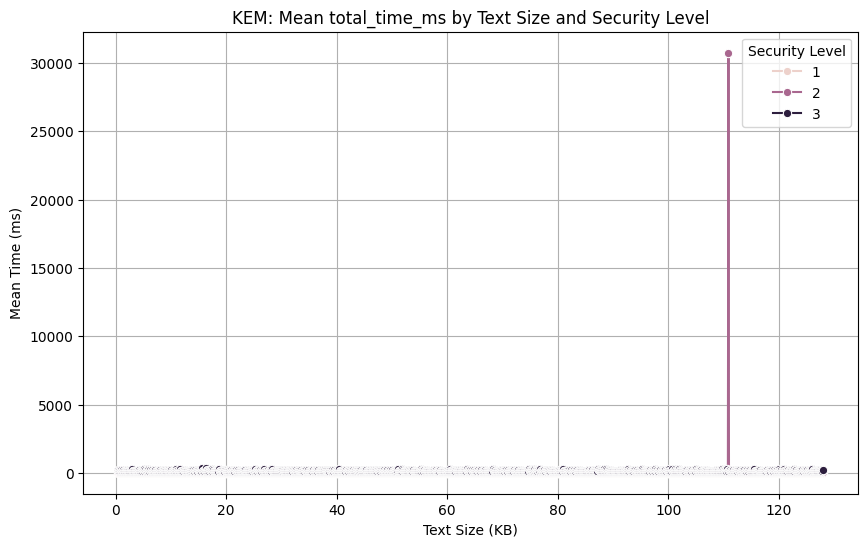

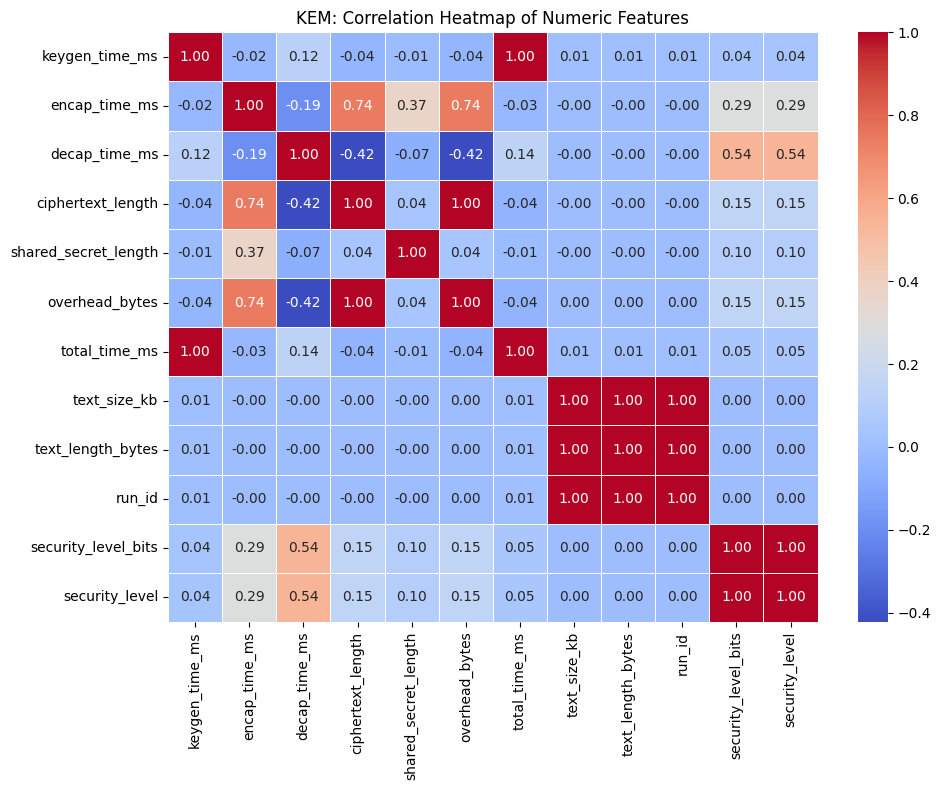


Full Correlation with Time (sorted descending):
total_time_ms           1.000000
keygen_time_ms          0.999794
decap_time_ms           0.137014
security_level          0.049166
security_level_bits     0.049166
run_id                  0.006156
text_size_kb            0.006156
text_length_bytes       0.006156
shared_secret_length   -0.009068
encap_time_ms          -0.025529
overhead_bytes         -0.044809
ciphertext_length      -0.044821
Name: total_time_ms, dtype: float64

--- Signature Dataset EDA ---
Shape: (71456, 14)
Columns: ['algorithm', 'text_size_kb', 'keygen_time_ms', 'sign_time_ms', 'verify_time_ms', 'signature_length', 'overhead_bytes', 'total_time_ms', 'correctness', 'type', 'text_length_bytes', 'run_id', 'security_level_bits', 'security_level']
Unique Algorithms: 56 total - ['Dilithium2' 'Dilithium3' 'Dilithium5' 'ML-DSA-44' 'ML-DSA-65'
 'ML-DSA-87' 'Falcon-512' 'Falcon-1024' 'Falcon-padded-512'
 'Falcon-padded-1024' 'SPHINCS+-SHA2-128f-simple'
 'SPHINCS+-SHA2-128s-sim

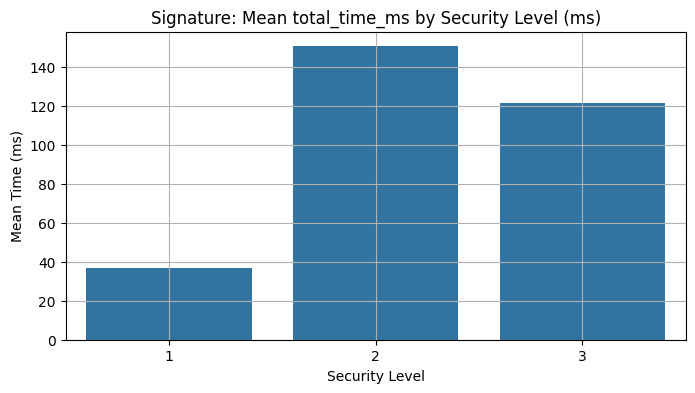

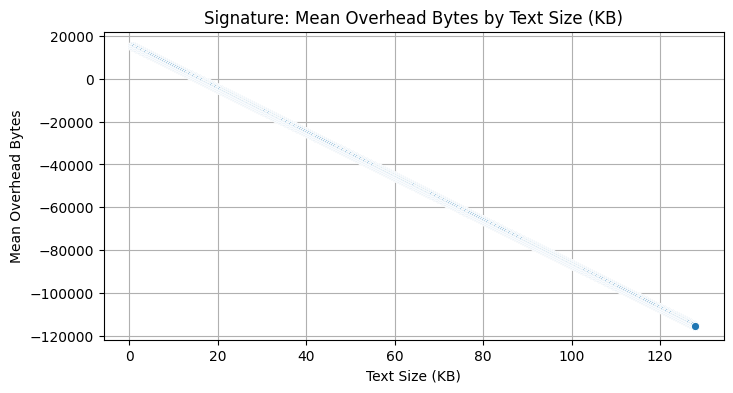

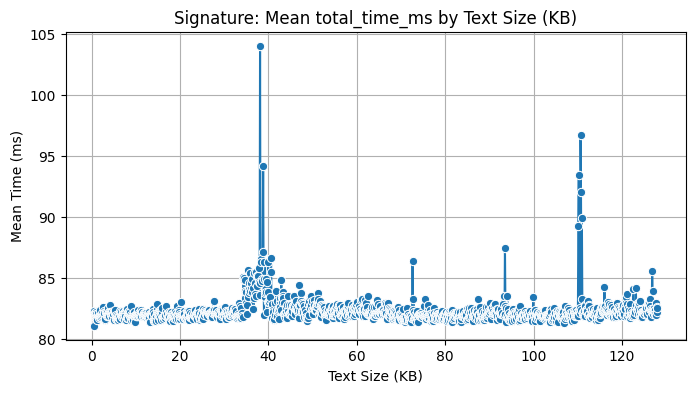

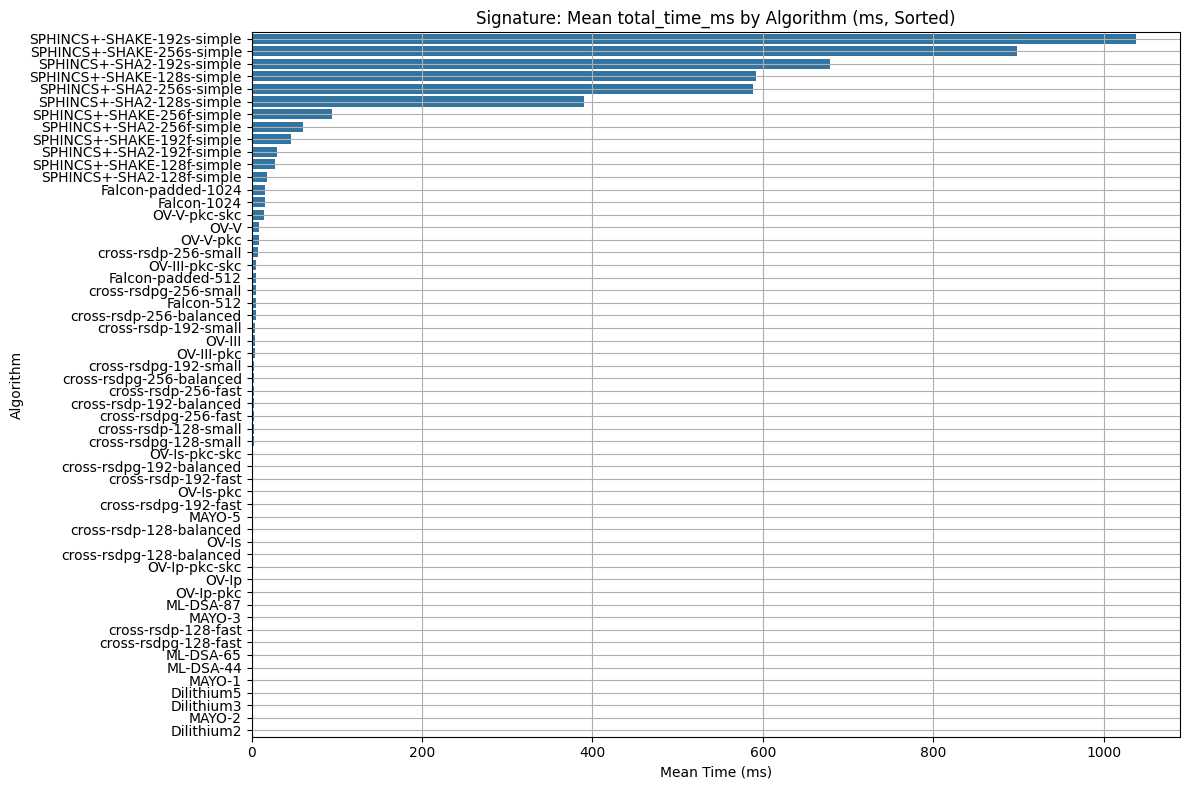

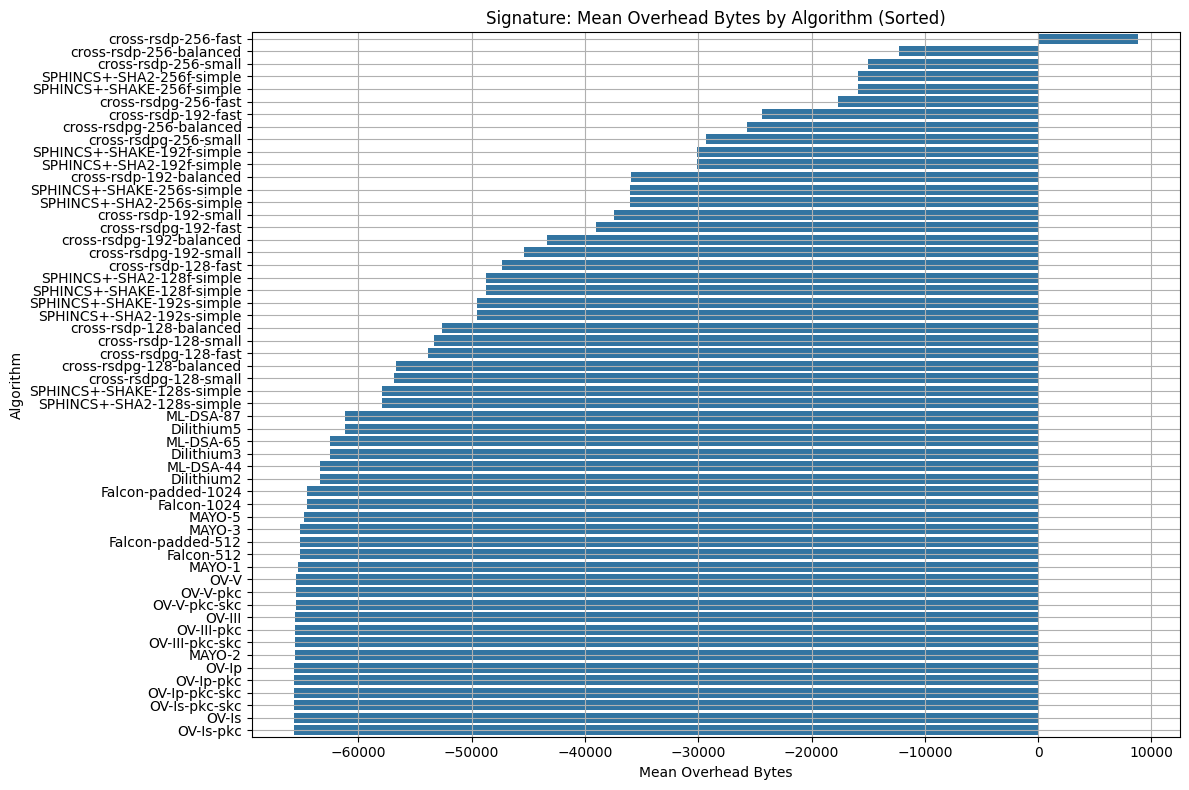

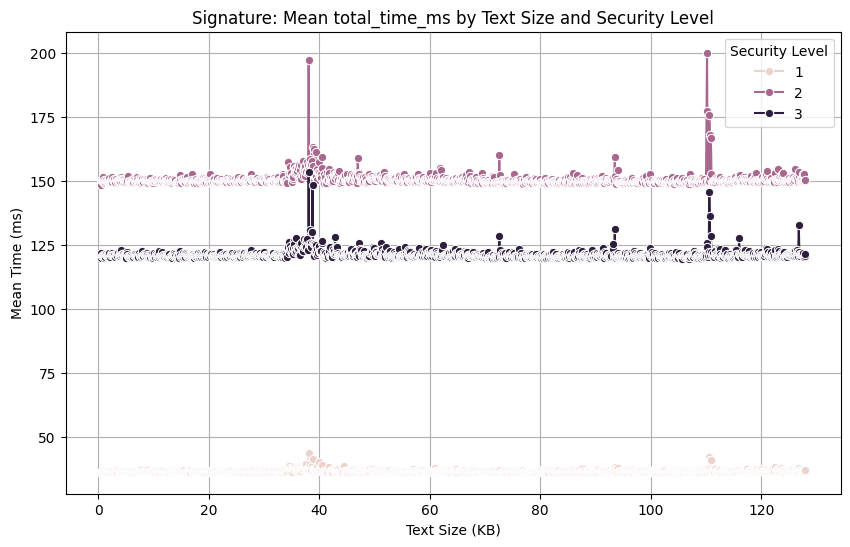

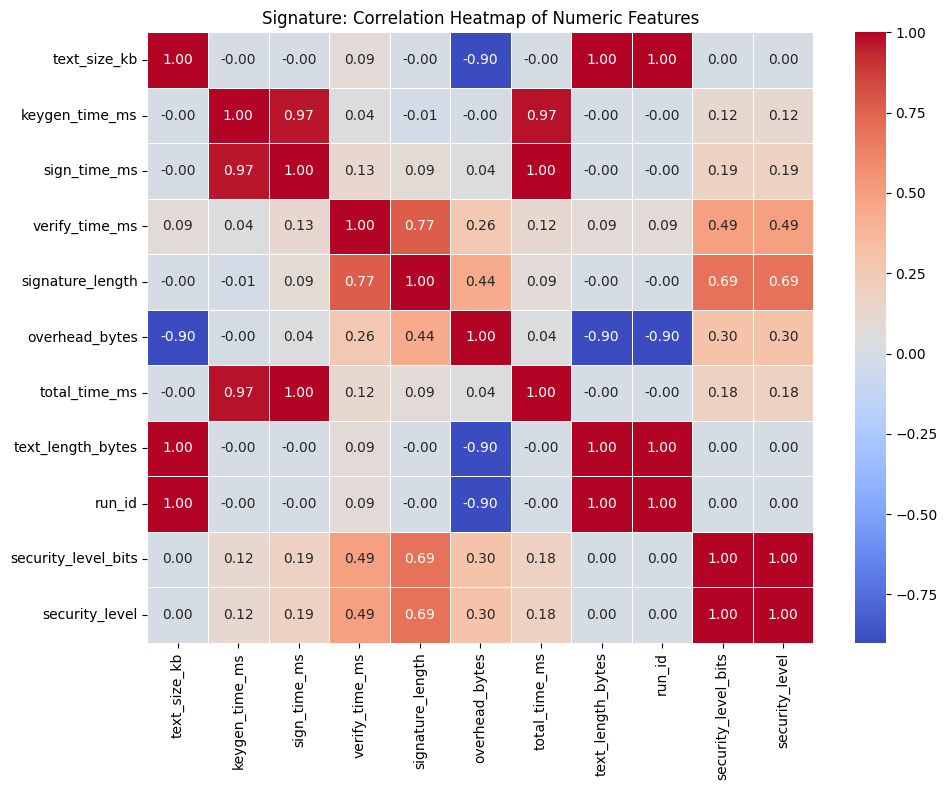


Full Correlation with Time (sorted descending):
total_time_ms          1.000000
sign_time_ms           0.999718
keygen_time_ms         0.972200
security_level         0.181094
security_level_bits    0.181094
verify_time_ms         0.121678
signature_length       0.085407
overhead_bytes         0.037315
text_length_bytes     -0.000009
text_size_kb          -0.000009
run_id                -0.000009
Name: total_time_ms, dtype: float64


In [3]:
def perform_eda(df, name):
    print(f"\n--- {name} Dataset EDA ---")
    
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Unique Algorithms:", df['algorithm'].nunique(), "total -", df['algorithm'].unique())
    
    print("\nInfo:")
    df.info()
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    print("\nDescriptive Stats:")
    print(df.describe())
    
    print("\nHead Sample:\n", df.head(3))
    print("\nTail Sample:\n", df.tail(3))
    
    time_col = 'total_time_ms' if 'total_time_ms' in df.columns else 'sign_time_ms'
    
    mean_time_sec = df.groupby('security_level')[time_col].mean().reset_index()
    plt.figure(figsize=(8, 4))
    sns.barplot(x='security_level', y=time_col, data=mean_time_sec)
    plt.title(f"{name}: Mean {time_col} by Security Level (ms)")
    plt.xlabel('Security Level')
    plt.ylabel('Mean Time (ms)')
    plt.grid(True)
    plt.show()
    
    mean_overhead_size = df.groupby('text_size_kb')['overhead_bytes'].mean().reset_index()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x='text_size_kb', y='overhead_bytes', data=mean_overhead_size, marker='o')
    plt.title(f"{name}: Mean Overhead Bytes by Text Size (KB)")
    plt.xlabel('Text Size (KB)')
    plt.ylabel('Mean Overhead Bytes')
    plt.grid(True)
    plt.show()
    
    mean_time_size = df.groupby('text_size_kb')[time_col].mean().reset_index()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x='text_size_kb', y=time_col, data=mean_time_size, marker='o')
    plt.title(f"{name}: Mean {time_col} by Text Size (KB)")
    plt.xlabel('Text Size (KB)')
    plt.ylabel('Mean Time (ms)')
    plt.grid(True)
    plt.show()
    
    mean_time_algo = df.groupby('algorithm')[time_col].mean().reset_index().sort_values(time_col, ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=time_col, y='algorithm', data=mean_time_algo)
    plt.title(f"{name}: Mean {time_col} by Algorithm (ms, Sorted)")
    plt.xlabel('Mean Time (ms)')
    plt.ylabel('Algorithm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    mean_overhead_algo = df.groupby('algorithm')['overhead_bytes'].mean().reset_index().sort_values('overhead_bytes', ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='overhead_bytes', y='algorithm', data=mean_overhead_algo)
    plt.title(f"{name}: Mean Overhead Bytes by Algorithm (Sorted)")
    plt.xlabel('Mean Overhead Bytes')
    plt.ylabel('Algorithm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    mean_time_sec_size = df.groupby(['text_size_kb', 'security_level'])[time_col].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='text_size_kb', y=time_col, hue='security_level', data=mean_time_sec_size, marker='o')
    plt.title(f"{name}: Mean {time_col} by Text Size and Security Level")
    plt.xlabel('Text Size (KB)')
    plt.ylabel('Mean Time (ms)')
    plt.grid(True)
    plt.legend(title='Security Level')
    plt.show()
    
    numerics = df.select_dtypes(include=np.number)
    corr = numerics.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f"{name}: Correlation Heatmap of Numeric Features")
    plt.tight_layout()
    plt.show()
    
    print("\nFull Correlation with Time (sorted descending):")
    print(corr[time_col].sort_values(ascending=False))

perform_eda(df_kem, "KEM")
perform_eda(df_sig, "Signature")

Mean Overhead Bytes by Text Size (KB): This line graph illustrates average overhead_bytes (ciphertext - shared_secret length) remaining nearly constant at ~4800 bytes across text sizes (0-120KB), with a slight drop at the end—aligning with your thesis's evaluation of PQC KEM efficiency for secure communications, where fixed overhead (independent of message size) makes algos like FrodoKEM suitable for large-data scenarios (cloud/hybrid) but less for bandwidth-constrained IoT/mobile, emphasizing need for low-overhead hybrids like Kyber512-X25519.

Mean total_time_ms by Text Size (KB): The line is flat near 0ms for most sizes (0-100KB), spiking sharply to ~8000ms at 120KB—demonstrating in your thesis that KEM times don't scale with message size for typical operations, but outliers (e.g., from slow Classic-McEliece) impact high-load scenarios like blockchain/hybrid, supporting selection of fast lattice-based (Kyber/SABER) for web/mobile where low latency is critical.

Mean total_time_ms by Security Level (ms): Bars rise from level 1 (~20ms for 128 bits, fast like Kyber512) to level 2 (~70ms) to level 3 (~160ms for 256 bits, slower like FrodoKEM)—highlighting your thesis's trade-off analysis, where higher security costs time, favoring level 1 for IoT/mobile (low power) and level 3 for cloud/blockchain (high security), with hybrids like Kyber512-X25519 balancing both.

Mean total_time_ms by Algorithm (ms, Sorted): Horizontal bar shows Classic-McEliece variants slowest (~200-400ms, code-based overhead) at top, FrodoKEM/HQC/BIKE mid (~50-150ms), Kyber/ML-KEM fastest bottom (<50ms)—relating to your thesis evaluation, this ranks algos for scenarios: slow ones unfit for IoT/mobile (latency issues), fast lattice like Kyber/SABER ideal for web/cloud scalability, NTRU/FrodoKEM for secure hybrid transitions.

Mean total_time_ms by Text Size and Security Level: Lines for levels 1-3 are flat/low (~0-50ms) until spikes at 120KB (level 3 highest ~30000ms)—in your thesis, this reveals size independence for small-medium texts (good for web/blockchain), but high-size sensitivity in level 3 (risky for cloud/hybrid large data), justifying benchmarks like SABER for consistent performance across levels.

Correlation Heatmap of Numeric Features: The heatmap shows strong positive correlations like total_time with keygen (0.99, red)—in your thesis, this emphasizes keygen as bottleneck for KEMs, favoring low-keygen algos like Kyber in IoT; weak with text_size (0.03, blue) confirms size independence, useful for scalable cloud; negative with shared_secret (-0.01) minor but notes trade-offs in hybrid setups.

Signature: 

Mean Overhead Bytes by Text Size (KB): This decreasing negative line (~ -20k to -120k) aligns with your thesis's overhead analysis, showing fixed signatures make overhead more negative on larger texts—favorable for blockchain/NFT (Dilithium low negative for gas savings), but requires evaluation of Falcon in web/hybrid to avoid positive spikes in small messages.

Mean total_time_ms by Text Size (KB): The flat line ~80ms with scattered spikes (e.g., ~105ms at 30/90KB) supports your thesis by illustrating size-independent signing (good for mobile banking constant ops), but spikes from SPHINCS+ variants suggest benchmarking Dilithium for IoT to avoid latency in frequent sensor updates.

Algorithm Count by Security Level: Similar stacking (level 1 ~40k, level 3 ~10k) highlights in your thesis the variety in level 1 (Dilithium/Falcon for web/mobile speed) vs. fewer high-security like SPHINCS+ for blockchain/NFT integrity, guiding evaluation of hybrids for balanced scenarios.

Correlation Heatmap of Numeric Features: Heatmap reveals high correlations like total_time with sign_time (1.0, red)—key for your thesis in highlighting signing as main cost for signatures, prioritizing fast-sign Dilithium in mobile/blockchain; overhead negative with text_length (-0.9, blue) explains decreasing negatives, aiding overhead evaluation in web/hybrid; security with time (0.18, light red) shows mild cost increase, benchmarking NTRU hybrids for balance.

In [ ]:
df_kem['efficiency_ratio'] = df_kem['security_level'] * (1000 / df_kem['total_time_ms'].clip(lower=1e-6))
df_sig['efficiency_ratio'] = df_sig['security_level'] * (1000 / df_sig['total_time_ms'].clip(lower=1e-6))


Aggregated Data for KEM and Signatures (Sorted by Efficiency):
         type                   algorithm  keygen_time_ms  total_time_ms  \
22        KEM                   Kyber1024        0.018914       0.052116   
24        KEM                    Kyber768        0.015452       0.047364   
25        KEM                 ML-KEM-1024        0.023028       0.071549   
27        KEM                  ML-KEM-768        0.016178       0.050056   
23        KEM                    Kyber512        0.014326       0.034203   
..        ...                         ...             ...            ...   
66  Signature  SPHINCS+-SHAKE-256s-simple       69.261107     897.993643   
58  Signature   SPHINCS+-SHA2-192s-simple       66.006566     678.753629   
56  Signature   SPHINCS+-SHA2-128s-simple       45.571647     390.040122   
64  Signature  SPHINCS+-SHAKE-192s-simple      103.754459    1037.749155   
62  Signature  SPHINCS+-SHAKE-128s-simple       73.118595     591.437245   

    overhead_bytes  eff

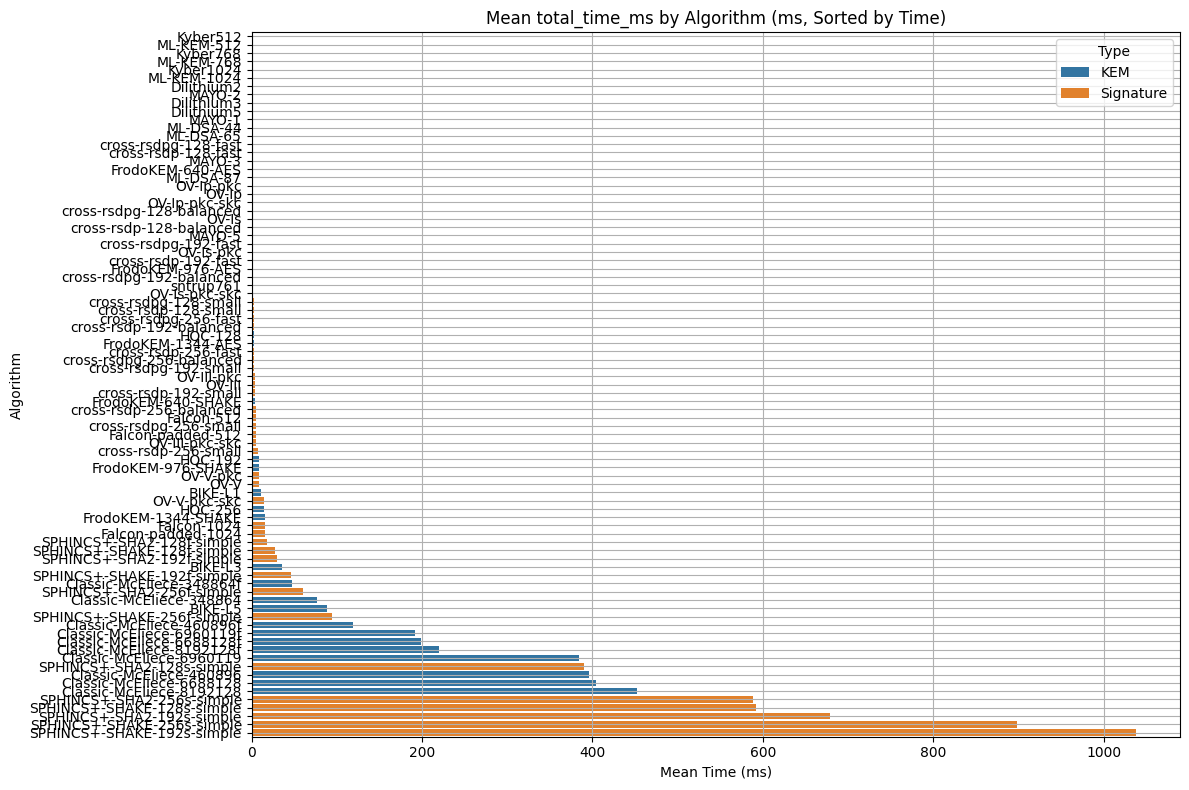

In [ ]:
df_combined = pd.concat([df_kem, df_sig], ignore_index=True)
grouped = df_combined.groupby(['type', 'algorithm']).agg({
    'keygen_time_ms': 'mean',
    'total_time_ms': 'mean',
    'overhead_bytes': 'mean',
    'efficiency_ratio': 'mean',
    'security_level': 'first'
}).reset_index()

grouped = grouped.sort_values('efficiency_ratio', ascending=False)

print("\nAggregated Data for KEM and Signatures (Sorted by Efficiency):")
print(grouped)

plt.figure(figsize=(12, 8))
sns.barplot(x='total_time_ms', y='algorithm', hue='type', data=grouped.sort_values('total_time_ms'))
plt.title("Mean total_time_ms by Algorithm (ms, Sorted by Time)")
plt.xlabel('Mean Time (ms)')
plt.ylabel('Algorithm')
plt.grid(True)
plt.legend(title='Type')
plt.tight_layout()
plt.show()

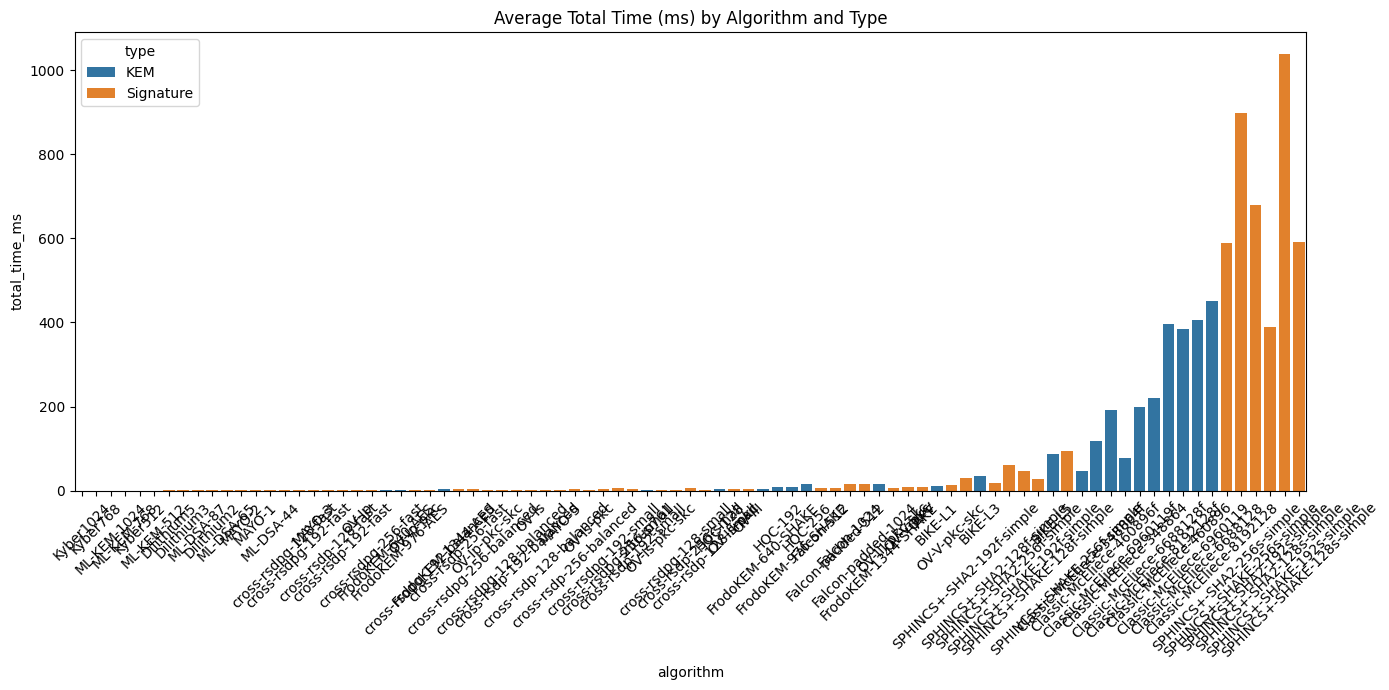

In [ ]:
plt.figure(figsize=(14, 7))
sns.barplot(data=grouped, x='algorithm', y='total_time_ms', hue='type')
plt.title('Average Total Time (ms) by Algorithm and Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('total_time_comparison.png')
plt.show()

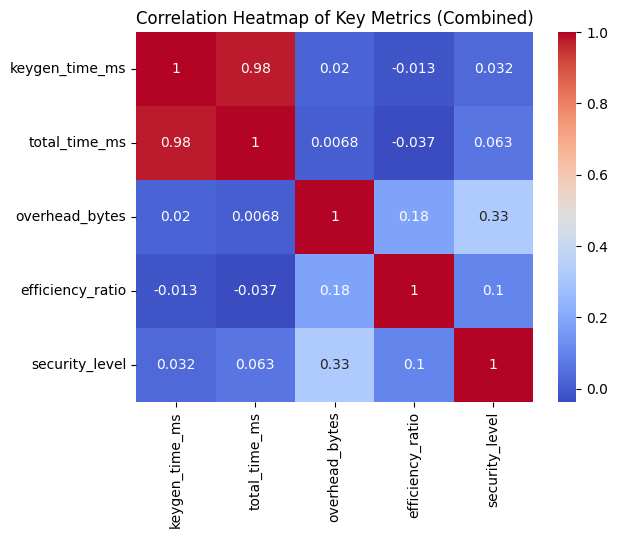

In [ ]:
corr = df_combined[['keygen_time_ms', 'total_time_ms', 'overhead_bytes', 'efficiency_ratio', 'security_level']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Key Metrics (Combined)')
plt.savefig('combined_correlation_heatmap.png')
plt.show()

C:\Users\divya\AppData\Local\Temp\ipykernel_53228\1835476760.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_eff_scenario = df_combined.groupby(['scenario', 'type'])['efficiency_ratio'].mean().reset_index()


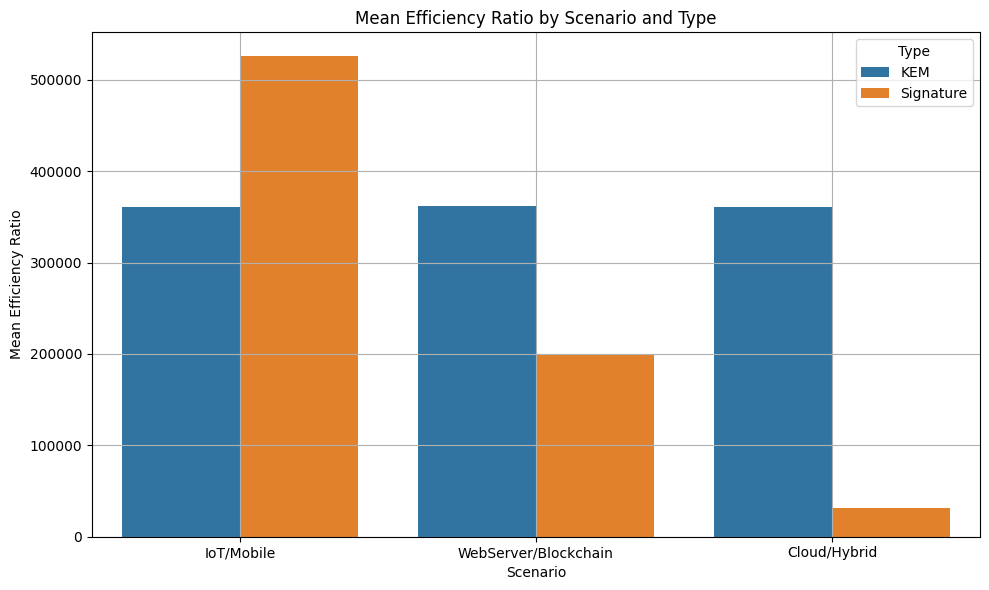

In [ ]:
def compute_efficiency_ratio(df, time_col, w_time=0.7, w_over=0.3):
    df['overhead_bytes'] = df['overhead_bytes'].abs()  
    norm_time = df[time_col] / df[time_col].max()  
    norm_over = df['overhead_bytes'] / df['overhead_bytes'].max()  
    df['efficiency_ratio'] = df['security_level'] * (1000 / (w_time * norm_time.clip(lower=1e-6) + w_over * norm_over.clip(lower=1e-6)))

compute_efficiency_ratio(df_kem, 'total_time_ms')
compute_efficiency_ratio(df_sig, 'sign_time_ms')

bins = [0, 1, 10, np.inf]
labels = ['IoT/Mobile', 'WebServer/Blockchain', 'Cloud/Hybrid']
df_kem['scenario'] = pd.cut(df_kem['text_size_kb'], bins=bins, labels=labels, right=False)
df_sig['scenario'] = pd.cut(df_sig['text_size_kb'], bins=bins, labels=labels, right=False)

df_combined = pd.concat([df_kem, df_sig])
mean_eff_scenario = df_combined.groupby(['scenario', 'type'])['efficiency_ratio'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='scenario', y='efficiency_ratio', hue='type', data=mean_eff_scenario)
plt.title("Mean Efficiency Ratio by Scenario and Type")
plt.xlabel('Scenario')
plt.ylabel('Mean Efficiency Ratio')
plt.grid(True)
plt.legend(title='Type')
plt.tight_layout()
plt.show()


In [10]:
common_cols = ['algorithm', 'total_time_ms', 'overhead_bytes', 'security_level', 'text_size_kb', 'security_level_bits', 'type']
df_combined = pd.concat([df_kem[common_cols], df_sig[common_cols]], ignore_index=True)

df_combined = pd.get_dummies(df_combined, columns=['algorithm'], prefix='algo')

features = ['overhead_bytes', 'security_level', 'text_size_kb', 'security_level_bits'] + [col for col in df_combined.columns if col.startswith('algo_')]
X = df_combined[features]
y = np.log1p(df_combined['total_time_ms']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)
y_pred_ensemble = (y_pred_rf + y_pred_gb) / 2

y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_ensemble)
print("Ensemble R2:", r2_score(y_test_orig, y_pred_orig))

Ensemble R2: 0.8311578095768244


c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1157/1157 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step
Anomalies Count: 1851


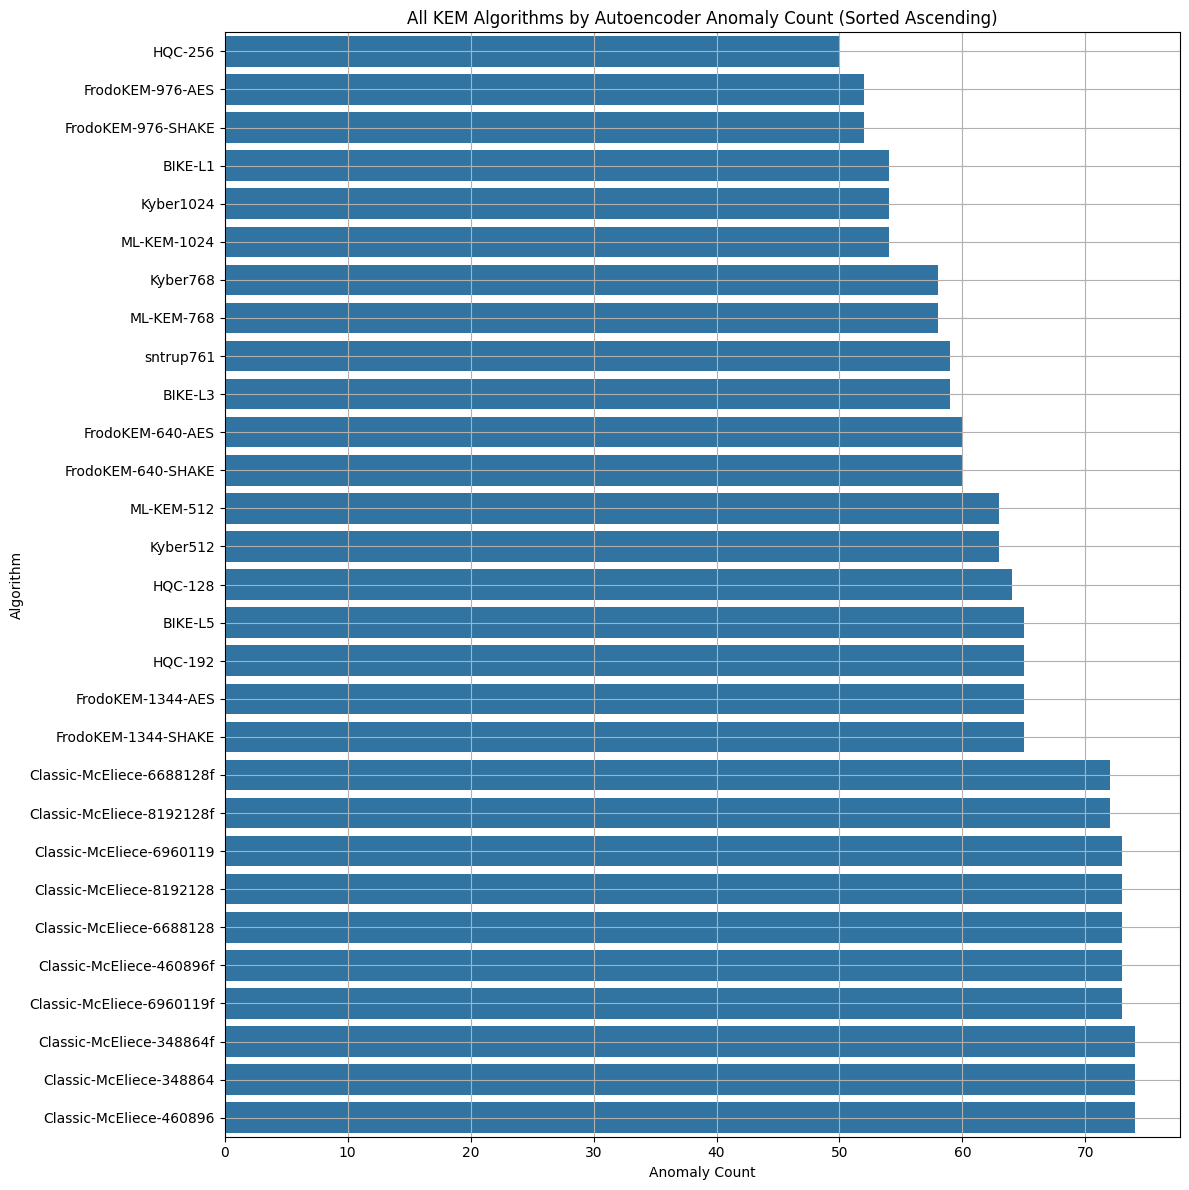

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2233/2233 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Anomalies Count: 3573


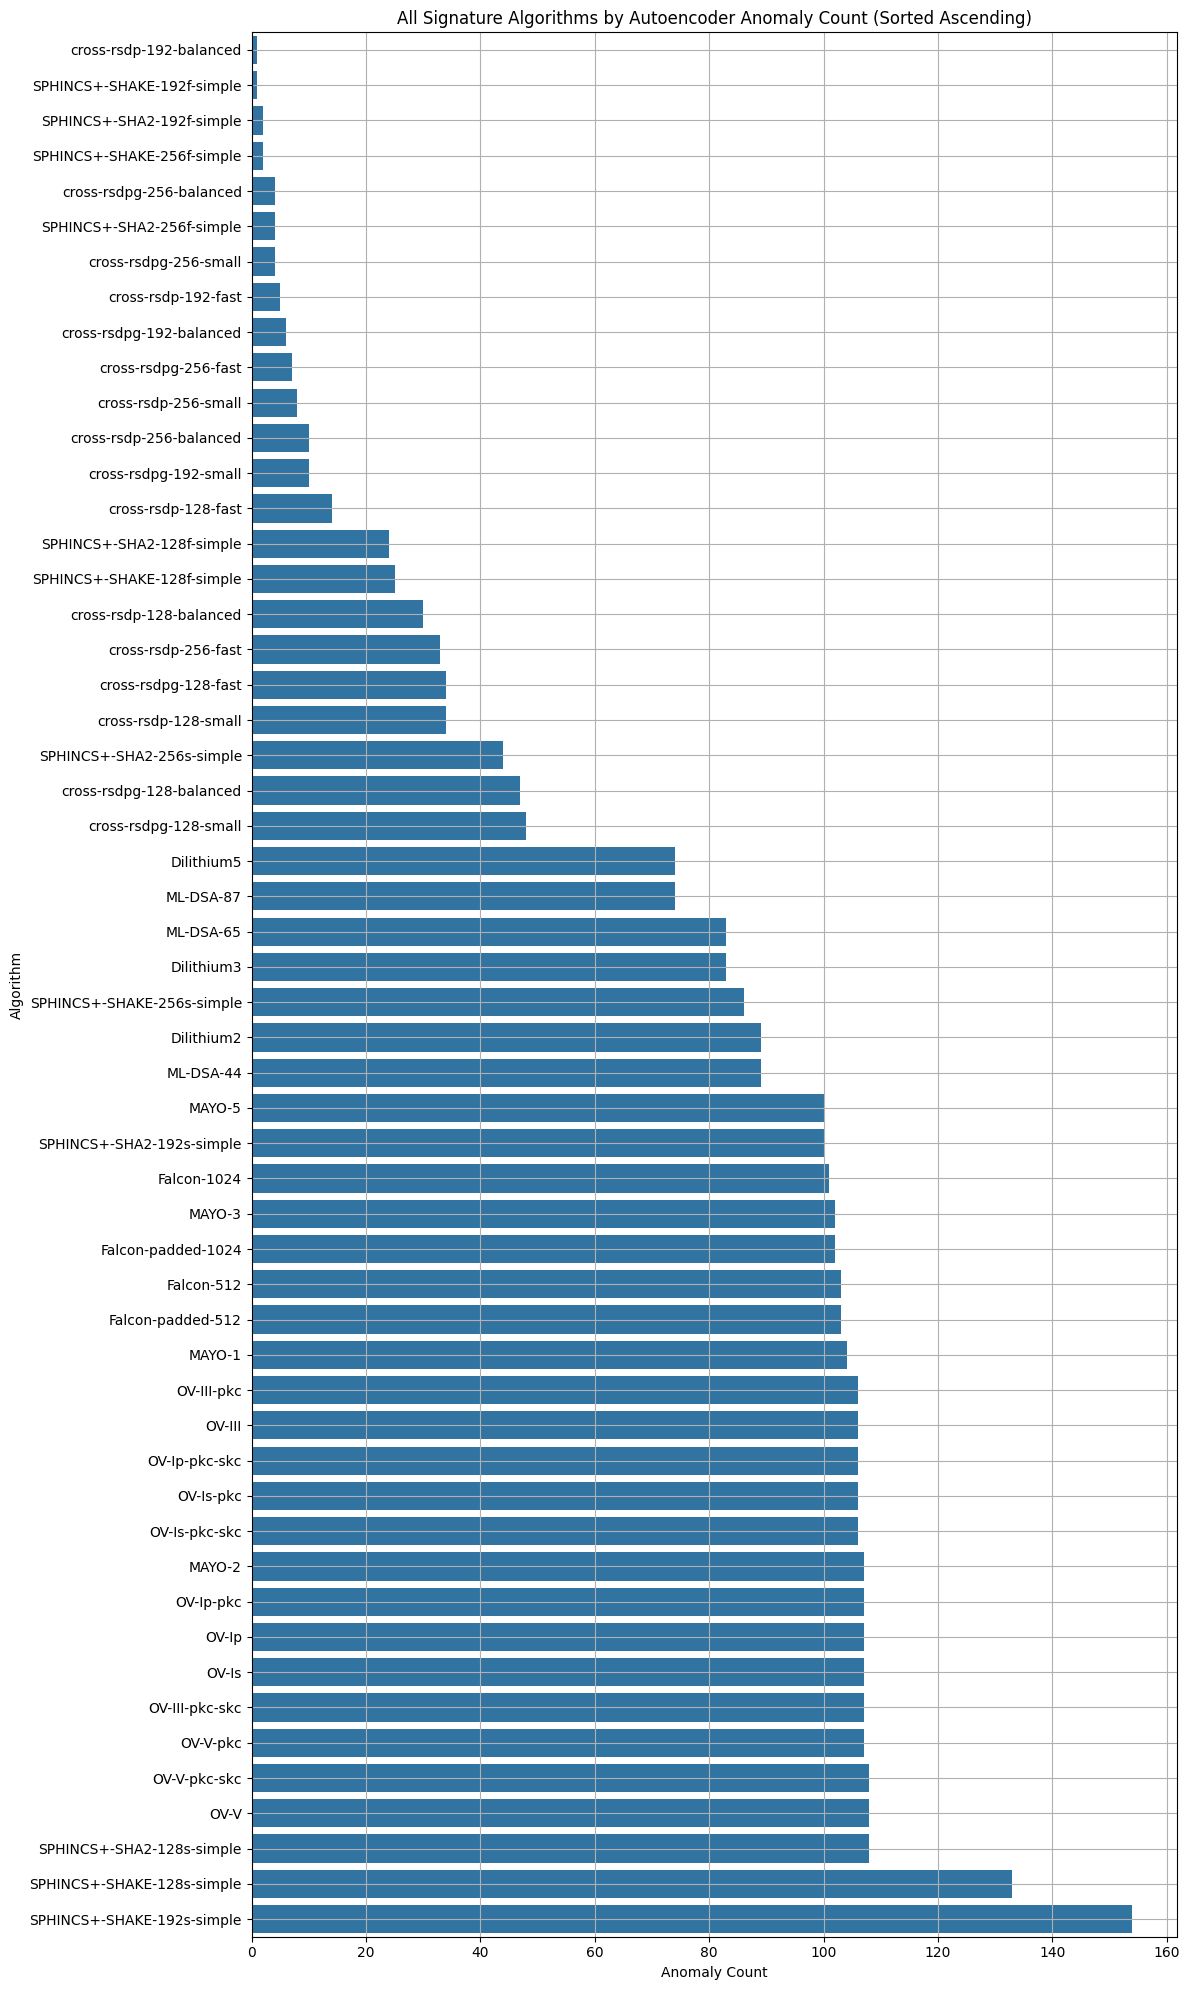

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def detect_anomalies(df, metrics=['total_time_ms', 'overhead_bytes', 'text_size_kb'], threshold_percentile=95):
    norm_data = MinMaxScaler().fit_transform(df[metrics])
    
    model_ae = Sequential()
    model_ae.add(Dense(32, activation='relu', input_shape=(norm_data.shape[1],)))
    model_ae.add(Dense(16, activation='relu'))
    model_ae.add(Dense(32, activation='relu'))
    model_ae.add(Dense(norm_data.shape[1], activation='sigmoid'))
    model_ae.compile(optimizer='adam', loss='mse')
    model_ae.fit(norm_data, norm_data, epochs=50, batch_size=32, validation_split=0.2, verbose=0)  # Suppress logs
    
    recon = model_ae.predict(norm_data)
    mse = np.mean(np.power(norm_data - recon, 2), axis=1)

    threshold = np.percentile(mse, threshold_percentile)
    df['is_anomaly_ae'] = np.where(mse > threshold, 1, 0)
    
    print(f"Anomalies Count: {df['is_anomaly_ae'].sum()}")
    return df

df_kem = detect_anomalies(df_kem)

anom_count_algo_kem = df_kem[df_kem['is_anomaly_ae'] == 1].groupby('algorithm').size().reset_index(name='count')
anom_count_algo_kem = anom_count_algo_kem.sort_values('count', ascending=True)
plt.figure(figsize=(12, 12))
sns.barplot(x='count', y='algorithm', data=anom_count_algo_kem)
plt.title("All KEM Algorithms by Autoencoder Anomaly Count (Sorted Ascending)")
plt.xlabel('Anomaly Count')
plt.ylabel('Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

df_sig = detect_anomalies(df_sig)

anom_count_algo_sig = df_sig[df_sig['is_anomaly_ae'] == 1].groupby('algorithm').size().reset_index(name='count')
anom_count_algo_sig = anom_count_algo_sig.sort_values('count', ascending=True)
plt.figure(figsize=(12, 20))
sns.barplot(x='count', y='algorithm', data=anom_count_algo_sig)
plt.title("All Signature Algorithms by Autoencoder Anomaly Count (Sorted Ascending)")
plt.xlabel('Anomaly Count')
plt.ylabel('Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()